In [28]:
import numpy as np
import pandas as pd

Definimos las variables

In [2]:
N = 25*12 # Número de meses
r = np.zeros([N+1, N+1]) # Arbol Binomial
Q = np.zeros([N+1, N+1]) # Precios Arrow-Debreu
theta = np.zeros(N+1) # Drift
dt = 1/12 # Delta t
#sigma = 0.001006449405907745 # Volatilidad De solo el 2025
sigma  = 100*10**-4

Llenar estado inicial

In [7]:
r[0][0] = 0.04761 # Tasa inicial
Q[0][0] = 1 # Precio inicial

# Leer factores de descuento
with open('df.txt', 'r') as archivo:
    discount_factors = archivo.read()
    discount_factors = discount_factors.split(',')
    for i in range(len(discount_factors)):
        discount_factors[i] = float(discount_factors[i])
    P = np.array(discount_factors)

theta[0] = (1/dt ** 2) * (np.log((np.exp(-r[0][0] * dt) + np.exp(-(r[0][0] + 2 * sigma * np.sqrt(dt)) * dt)) / (2 * P[1]))) + sigma/np.sqrt(dt)

301


Tasas nivel 1

In [4]:
r[1][1] = r[0][0] + theta[0]*dt + sigma*np.sqrt(dt)
r[0][1] = r[0][0] + theta[0]*dt - sigma*np.sqrt(dt)

Iteración de cada nivel

In [262]:
for j in range(1,N):

    # Precios Arrow-Debreu
    for i in range(0, j+1):
        if i == 0:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * Q[i][j-1]
        elif i == j:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * Q[j-1][j-1]
        else:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * (Q[i-1][j-1] + Q[i][j-1])
    
    # f auxiliar
    f = Q[0][j]*np.exp(-r[0][j] * dt) + sum([(Q[k-1][j] + Q[k][j])*np.exp(-r[k][j] * dt) for k in range(1, j+1)]) + Q[j][j]*np.exp(-(r[0][0] + 2 * sigma * np.sqrt(dt)) * dt)
    # theta
    theta[j] = (1/dt ** 2) * np.log(f / (2 * P[j+1])) + sigma/np.sqrt(dt)

    # Tasas
    for i in range(0, j+1):
        r[i][j+1] = r[i][j] + theta[j]*dt - sigma*np.sqrt(dt)
    r[j+1][j+1] = r[j][j] + theta[j]*dt + sigma*np.sqrt(dt)

In [128]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(r: np.ndarray, dt: float, title="Lattice de Ho–Lee"):
    """
    r: matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
       r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt: tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt

    fig, ax = plt.subplots(figsize=(10, 5))

    # Dibujar aristas (padre j -> hijos en j+1)
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i, j+1]],
                        color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i+1, j+1]],
                        color="red", lw=0.8)

    # (Opcional) marcar nodos
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # Formato ejes
    ax.set_xlim(T[0], T[-1])
    ymin = np.nanmin(r); ymax = np.nanmax(r)
    ylim = max(abs(ymin), abs(ymax))
    pad = 0.05 * (ymax - ymin if np.isfinite(ymax - ymin) and ymax != ymin else 0.02)
    ax.set_ylim(-ylim - pad, ylim + pad)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # muestra % (r en decimal)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (meses)")
    ax.set_ylabel("Tasa")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

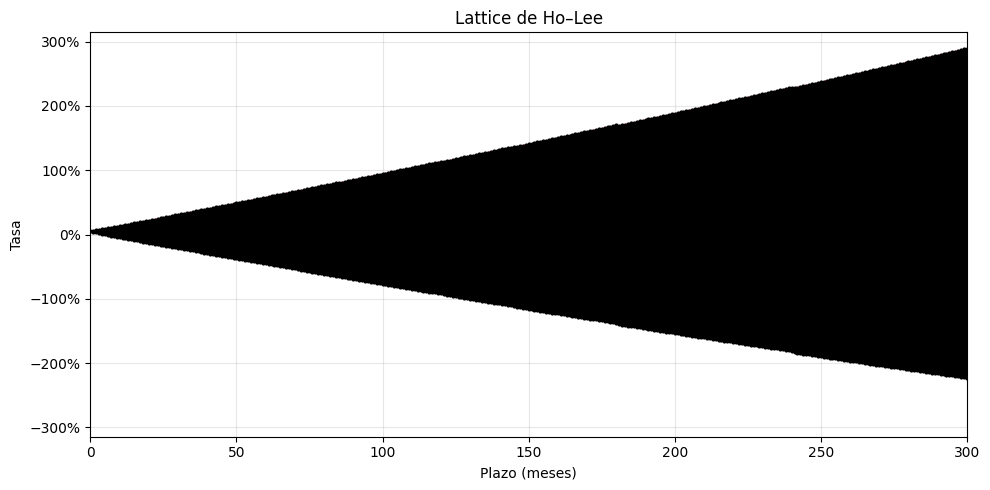

In [20]:
plot_ho_lee_lattice(r, 1)

In [173]:

from matplotlib.ticker import PercentFormatter
def pascal_factors_funct(m: int) -> np.array:
    pascal_factors = np.zeros([m,m])
    for j in range(m):
        for i in range(m):
            if i == 0 or i==j:
                pascal_factors[i][j] = 1
            else:
                pascal_factors[i][j] = pascal_factors[i][j-1] + pascal_factors[i-1][j-1]
    return pascal_factors

def esperanza(m: int, r: np.array, pascal_factors: np.array) -> np.array:
    expected_value = np.zeros(m+1)
    for t in range(m+1):
        expected_value[t] = 2 ** (-t)*np.dot(r[:,t], pascal_factors[:,t])
    return expected_value
def plot_ho_lee_lattice(
    r: np.ndarray,
    dt: float,
    sigma: float,
    title: str = "Lattice de Ho–Lee",
    mostrar_esperanza: bool = False
):
    """
    r : matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
        r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt : tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    sigma : volatilidad anual (decimal)
    mostrar_esperanza : si True, traza E[r_t] usando pascal_factors_funct y esperanza
                        (deben existir en el namespace)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje en años

    fig, ax = plt.subplots(figsize=(10, 5))

    # --- aristas del lattice ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i, j+1]], color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i+1, j+1]], color="red", lw=0.8)

    # --- nodos ---
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # --- esperanza por tenor (opcional) ---
    if mostrar_esperanza:
        m = n  # nº total de pasos (meses si dt=1/12)
        # llamamos a TUS funciones (se asume que están definidas en tu entorno)
        pascal_factors = pascal_factors_funct(m+1)
        mu = esperanza(m, r, pascal_factors)  # vector de largo m+1
        ax.plot(T, mu, lw=2.2, color="blue", label="Valor esperado en plazo t")
        ax.legend(loc="upper left")

    # formato ejes
    ax.set_xlim(T[0], T[-1])
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # r en %
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Tasa")

    # título con sigma en bps
    bps = sigma
    print(sigma)
    ax.set_title(f"{title} calibrado a mercado 15 septiembre de 2025 con volatilidad σ = {round(sigma*100*100,2)}bps")
    plt.savefig("holee_hist.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.tight_layout()
    plt.show()


0.001006449405907745


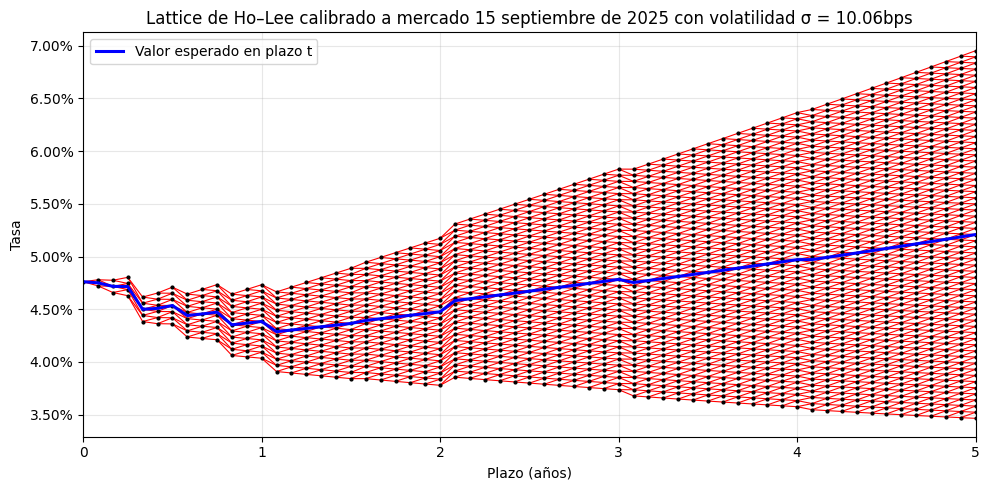

In [174]:
plot_ho_lee_lattice(r, 1/12, sigma, mostrar_esperanza = True)

In [244]:
pascal_factors = pascal_factors_funct(N+1)
mu = esperanza(N, r, pascal_factors)  # vector de largo m+1

In [145]:
print(P[:len(mu)], len(P[:len(mu)]))

[1.         0.99604901 0.99214551 0.98825215 0.98455441 0.98085666
 0.97715891 0.97355104 0.96994317 0.96633529 0.96283692 0.95933855
 0.95584018 0.9524315  0.94902281 0.94561413 0.94220544 0.93879675
 0.93538807 0.93196949 0.9285509  0.92513232 0.92171373 0.91829515
 0.91487657 0.91139014 0.9079037  0.90441727 0.90093084 0.89744441
 0.89395798 0.89047155 0.88698512 0.88349869 0.88001226 0.87652583
 0.8730394  0.86958835 0.86613729 0.86268624 0.85923519 0.85578414
 0.85233309 0.84888204 0.84543098 0.84197993 0.83852888 0.83507783
 0.83162678 0.82818955 0.82475233 0.8213151  0.81787788 0.81444065
 0.81100343 0.8075662  0.80412898 0.80069175 0.79725453 0.7938173
 0.79038008 0.78700137 0.78362266 0.78024395 0.77686524 0.77348653
 0.77010782 0.7667291  0.76335039 0.75997168 0.75659297 0.75321426
 0.74983555 0.74645684 0.74307813 0.73969942 0.73632071 0.732942
 0.72956329 0.72618458 0.72280587 0.71942716 0.71604845 0.71266974
 0.70929103 0.70616076 0.70303048 0.69990021 0.69676993 0.6936396

In [177]:
rt = (1/P[:len(mu)]-1)*360/(30*np.array([i for i in range(N+1)]))
rt[0]= 0.04761
rt

/var/folders/k6/x0pwglw92_74wdc5stx1kj0m0000gn/T/ipykernel_1473/319423370.py:1: RuntimeWarning: invalid value encountered in divide
  rt = (1/P[:len(mu)]-1)*360/(30*np.array([i for i in range(N+1)]))


array([0.04761   , 0.0476    , 0.0475    , 0.04755   , 0.04706371,
       0.04684071, 0.04675   , 0.04657288, 0.04648236, 0.04645   ,
       0.04631697, 0.04623805, 0.0462    , 0.04610241, 0.04604181,
       0.04601105, 0.04600474, 0.04601879, 0.04605   , 0.04610306,
       0.04616813, 0.04624369, 0.04632848, 0.04642148, 0.04652181,
       0.04666798, 0.04681772, 0.04697081, 0.04712705, 0.04728627,
       0.04744832, 0.0476131 , 0.04778049, 0.0479504 , 0.04812276,
       0.04829749, 0.04847456, 0.04863873, 0.0488057 , 0.04897538,
       0.04914771, 0.04932262, 0.04950007, 0.04967999, 0.04986236,
       0.05004714, 0.05023429, 0.05042379, 0.05061562, 0.05080483,
       0.05099645, 0.05119047, 0.05138687, 0.05158563, 0.05178676,
       0.05199023, 0.05219606, 0.05240423, 0.05261474, 0.0528276 ,
       0.05304282])

<function matplotlib.pyplot.show(close=None, block=None)>

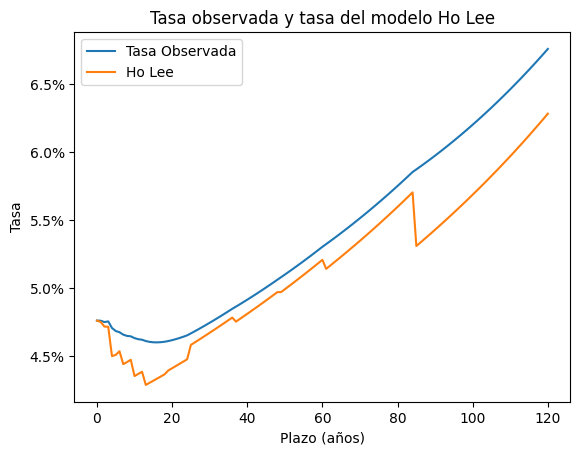

In [168]:
x = np.array([i for i in range(N+1)])
plt.plot(x, rt*100, label= "Tasa Observada")
plt.plot(x, mu*100, label= "Ho Lee")
plt.title("Tasa observada y tasa del modelo Ho Lee")
plt.xlabel("Plazo (años)")
plt.ylabel("Tasa")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=1))
plt.legend()
plt.show

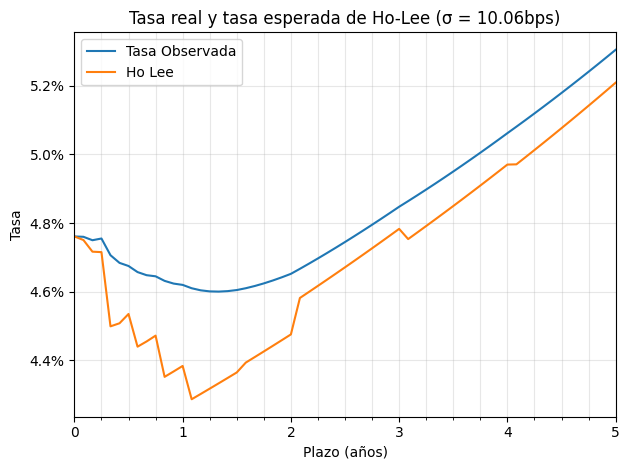

In [183]:
from matplotlib.ticker import PercentFormatter, MultipleLocator
import numpy as np
import matplotlib.pyplot as plt

x_months = np.arange(N+1)
x_years  = x_months / 12.0     # <-- meses → años

plt.plot(x_years, rt*100, label="Tasa Observada")
plt.plot(x_years, mu*100, label="Ho Lee")

ax = plt.gca()
ax.set_title("Tasa real y tasa esperada de Ho-Lee (σ = 10.06bps)")
ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Tasa")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=1))

# Ticks del eje X: mayor cada 1 año, menores cada 0.25 años (trimestral)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlim(0, x_years[-1])

ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.savefig("holeevstasareal.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.tight_layout()
plt.show()


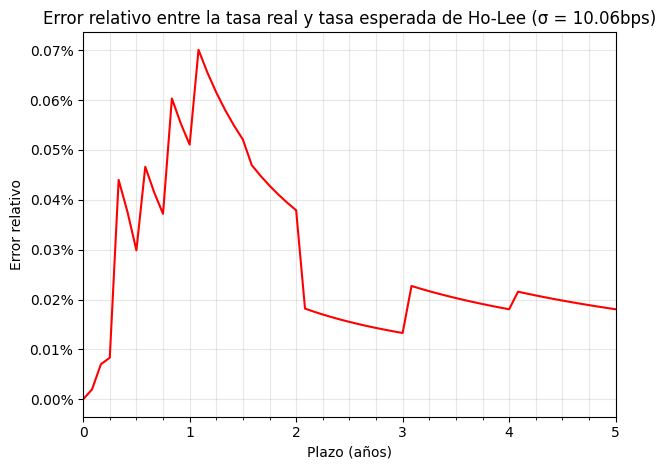

In [184]:

x_months = np.arange(N+1)
x_years  = x_months / 12.0     # <-- meses → años

plt.plot(x_years, abs(rt-mu)/abs(rt), color="r")

ax = plt.gca()
ax.set_title("Error relativo entre la tasa real y tasa esperada de Ho-Lee (σ = 10.06bps)")
ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Error relativo")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=2))

# Ticks del eje X: mayor cada 1 año, menores cada 0.25 años (trimestral)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlim(0, x_years[-1])

ax.grid(True, which="both", alpha=0.3)
plt.savefig("holeevstasareal_error.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.tight_layout()
plt.show()


In [164]:
sigma

0.001006449405907745

In [185]:
rt

array([0.04761   , 0.0476    , 0.0475    , 0.04755   , 0.04706371,
       0.04684071, 0.04675   , 0.04657288, 0.04648236, 0.04645   ,
       0.04631697, 0.04623805, 0.0462    , 0.04610241, 0.04604181,
       0.04601105, 0.04600474, 0.04601879, 0.04605   , 0.04610306,
       0.04616813, 0.04624369, 0.04632848, 0.04642148, 0.04652181,
       0.04666798, 0.04681772, 0.04697081, 0.04712705, 0.04728627,
       0.04744832, 0.0476131 , 0.04778049, 0.0479504 , 0.04812276,
       0.04829749, 0.04847456, 0.04863873, 0.0488057 , 0.04897538,
       0.04914771, 0.04932262, 0.04950007, 0.04967999, 0.04986236,
       0.05004714, 0.05023429, 0.05042379, 0.05061562, 0.05080483,
       0.05099645, 0.05119047, 0.05138687, 0.05158563, 0.05178676,
       0.05199023, 0.05219606, 0.05240423, 0.05261474, 0.0528276 ,
       0.05304282])

In [263]:
pascal_factors = pascal_factors_funct(N+1)
mu = esperanza(N, r, pascal_factors)  # vector de largo m+1
forward = np.zeros(len(mu))

#for i in range(1, len(mu)):
#    forward[i] = (np.log(P[i-1])-np.log(P[i]))/(i- (i-1))
#print(forward)

for i in range(1, len(mu)):
    forward[i] = (P[i-1]/P[i] - 1)*12
forward[0] = 0.04761

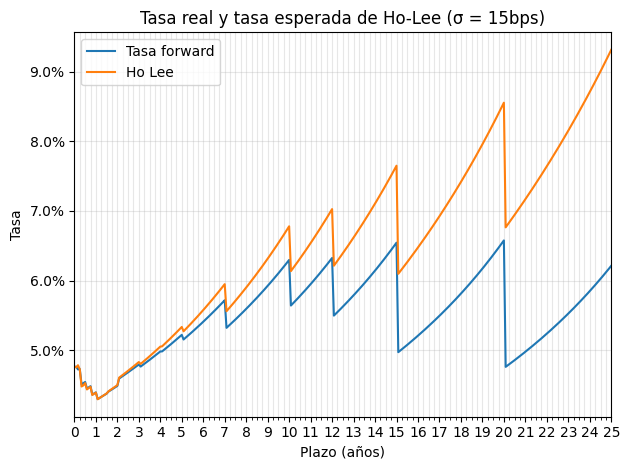

In [264]:
x_months = np.arange(N+1)
x_years  = x_months / 12.0     # <-- meses → años

plt.plot(x_years, forward*100, label="Tasa forward")
plt.plot(x_years, mu*100, label="Ho Lee")

ax = plt.gca()
ax.set_title("Tasa real y tasa esperada de Ho-Lee (σ = 15bps)")
ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Tasa")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=1))

# Ticks del eje X: mayor cada 1 año, menores cada 0.25 años (trimestral)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlim(0, x_years[-1])

ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.savefig("forwardvsholee.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.tight_layout()
plt.show()

In [197]:
rt

array([0.04761   , 0.0476    , 0.0475    , 0.04755   , 0.04706371,
       0.04684071, 0.04675   , 0.04657288, 0.04648236, 0.04645   ,
       0.04631697, 0.04623805, 0.0462    , 0.04610241, 0.04604181,
       0.04601105, 0.04600474, 0.04601879, 0.04605   , 0.04610306,
       0.04616813, 0.04624369, 0.04632848, 0.04642148, 0.04652181,
       0.04666798, 0.04681772, 0.04697081, 0.04712705, 0.04728627,
       0.04744832, 0.0476131 , 0.04778049, 0.0479504 , 0.04812276,
       0.04829749, 0.04847456, 0.04863873, 0.0488057 , 0.04897538,
       0.04914771, 0.04932262, 0.04950007, 0.04967999, 0.04986236,
       0.05004714, 0.05023429, 0.05042379, 0.05061562, 0.05080483,
       0.05099645, 0.05119047, 0.05138687, 0.05158563, 0.05178676,
       0.05199023, 0.05219606, 0.05240423, 0.05261474, 0.0528276 ,
       0.05304282])

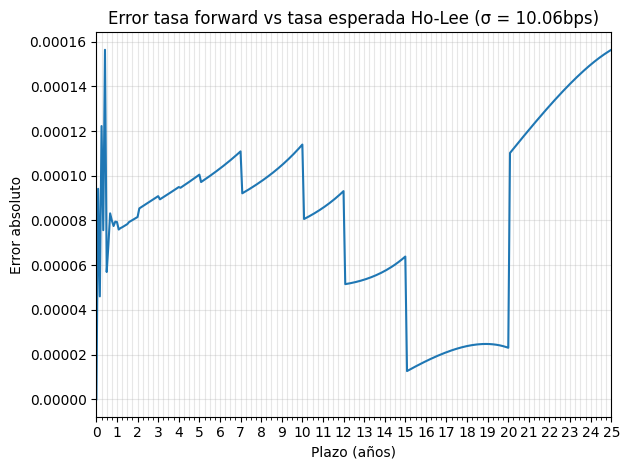

In [224]:
x_months = np.arange(N+1)
x_years  = x_months / 12.0     # <-- meses → años

plt.plot(x_years, abs(forward-mu))

ax = plt.gca()
ax.set_title("Error tasa forward vs tasa esperada Ho-Lee (σ = 10.06bps)")
ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Error absoluto")
#ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=3))

# Ticks del eje X: mayor cada 1 año, menores cada 0.25 años (trimestral)
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_xlim(0, x_years[-1])

ax.grid(True, which="both", alpha=0.3)
#plt.savefig("forwardvsholee.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.tight_layout()
plt.show()

In [8]:
forwards_1m = np.zeros(301)w

In [37]:
forwards_1m[0]= (1/discount_factors[0]-1)*12
for i in range(1,len(discount_factors)):
    forwards_1m[i] = (discount_factors[i-1]/discount_factors[i] - 1)*12
forwards_1m*100

array([0.        , 4.76      , 4.72127229, 4.72757338, 4.50690871,
       4.52389938, 4.54101864, 4.44706681, 4.46360845, 4.4802736 ,
       4.36007818, 4.37597786, 4.39199391, 4.29471609, 4.31014179,
       4.32567869, 4.34132802, 4.35709099, 4.37296884, 4.40175421,
       4.41795986, 4.43428527, 4.45073178, 4.46730074, 4.48399353,
       4.59047852, 4.60810637, 4.62587012, 4.64377136, 4.66181168,
       4.67999272, 4.69831612, 4.71678357, 4.73539677, 4.75415746,
       4.77306739, 4.79212835, 4.76232458, 4.78129967, 4.80042657,
       4.81970711, 4.83914315, 4.85873659, 4.87848933, 4.89840334,
       4.91848059, 4.9387231 , 4.95913292, 4.97971213, 4.98034558,
       5.0011016 , 5.02203134, 5.043137  , 5.0644208 , 5.08588502,
       5.10753195, 5.12936395, 5.15138338, 5.17359268, 5.19599431,
       5.21859078, 5.15177279, 5.17398546, 5.1963905 , 5.21899043,
       5.24178779, 5.2647852 , 5.28798529, 5.31139075, 5.33500433,
       5.35882881, 5.38286703, 5.40712187, 5.43159629, 5.45629

In [38]:
swap = np.zeros(len(discount_factors))
for i in range(1,len(discount_factors)):
    swap[i] = (1/discount_factors[i]-1)*12/i*100
len(swap)

301

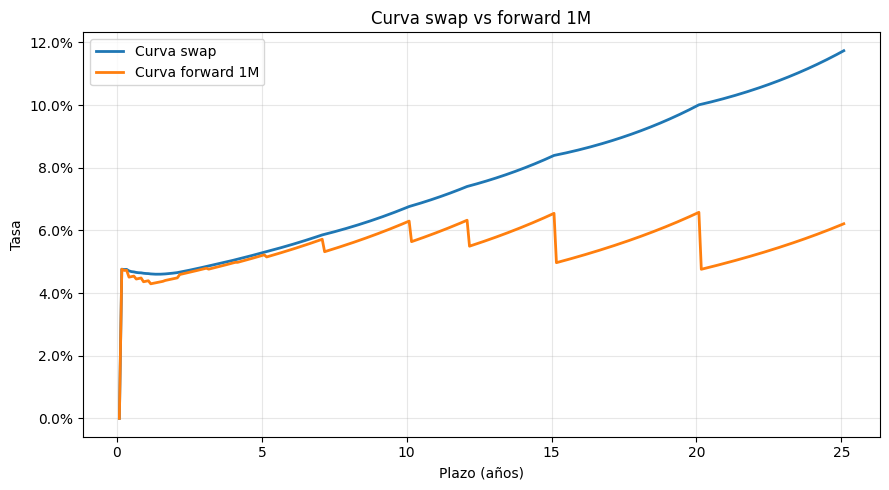

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# swap y forwards_1m deben existir como listas/arrays de tasas en decimales
# swap = [...]
# forwards_1m = [...]

# Alinea longitudes por si difieren
n = min(len(swap), len(forwards_1m))
swap = np.array(swap[:n], dtype=float)
fwd  = np.array(forwards_1m[:n], dtype=float)

# Eje x: meses -> años (1,2,...,n meses)
months = np.arange(1, n+1)
years  = months / 12.0

plt.figure(figsize=(9,5))
plt.plot(years, swap/100, label='Curva swap', lw=2)
plt.plot(years, fwd,  label='Curva forward 1M', lw=2)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))  # muestra en %
plt.xlabel('Plazo (años)')
plt.ylabel('Tasa')
plt.title('Curva swap vs forward 1M')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
N = 25*12 # Número de meses
r = np.zeros([N+1, N+1]) # Arbol Binomial
Q = np.zeros([N+1, N+1]) # Precios Arrow-Debreu
theta = np.zeros(N+1) # Drift
dt = 1/12 # Delta t
#sigma = 0.001006449405907745 # Volatilidad De solo el 2025
sigma  = 1/100

301

In [ ]:
theta[0] = (1/dt) * ()